In [33]:
import contextily as cx
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append('../utils')
from helper_functions import combine_zip_codes_and_county_geos, total_vehicles_and_evs_by_zip, city_geos

In [34]:
# Get a mapping of California zip codes to counties
# This also includes 2017 population
zip_code_path = "../geojsons/California_Zip_Codes.geojson"
counties_path = "../geojsons/California_County_Boundaries.geojson"
zip_county_mapper = combine_zip_codes_and_county_geos(zip_code_path, counties_path)[['zip_code', 'po_name', 'population', 'county_name', 'county_abbrev']]
zip_county_mapper.rename(columns = {'population': 'pop_2017'}, inplace = True)
zip_county_mapper.pop_2017 = zip_county_mapper.pop_2017.astype(str)

Reading in geojson files...
California has 1721 zip codes and 69 counties
Our join lost us 4 zip codes out of 1721


In [35]:
# Get California 2021 population
pop_2021 = pd.read_csv('../vehicle_data/california_pop_by_zip_code.csv', thousands=',')[['zip_code', 'population_2021']]
pop_2021.rename(columns = {'population_2021': 'pop_2021'}, inplace = True)
pop_2021 = pop_2021.astype({'zip_code': 'str', 'pop_2021': 'int64'})

# Join California 2021 population onto zip and county data
zip_county_mapper_final = zip_county_mapper.merge(pop_2021, on='zip_code', how='left')

In [36]:
# Column type dictionary for reading in vehicle csv data:
dtype_dict = {'Date': 'object', 
            'Zip Code': 'object',
            'Model Year': 'object',
            'Fuel': 'object',
            'Make': 'object',
            'Duty': 'object',
            'Vehicles': 'int64'
}

# Fuel type dictionary:
fuel_dict = {'Battery Electric': 'ZEV',
            'Diesel and Diesel Hybrid': 'Fuel',
            'Flex-Fuel': 'Fuel',
            'Gasoline': 'Fuel',
            'Hybrid Gasoline': 'Fuel',
            'Hydrogen Fuel Cell': 'ZEV',
            'Natural Gas': 'Fuel',
            'Other': 'Fuel',
            'Plug-in Hybrid': 'Hybrid'
}

newest_years = ['2022', '2021', '2020']

raw = pd.read_csv('../vehicle_data/vehicle-fuel-type-count-by-zip-code-2022.csv', dtype = dtype_dict)

# process data
raw.columns= raw.columns.str.lower()
raw['date']= pd.to_datetime(raw['date'])
raw['fuel (broad)'] = raw['fuel'].map(fuel_dict)
raw.rename(columns = {'fuel': 'fuel (specific)', 'zip code': 'zip_code'}, inplace = True)

# Grab only newest years
raw_newest = raw[raw['model year'].isin(newest_years)]

# Grab column for ev counts
raw_newest['evs'] = np.where(raw_newest['fuel (broad)'].isin(['ZEV', 'Hybrid']), raw_newest['vehicles'], 0)

/var/folders/zp/1zs8wctn76z_xxs9f2k7rwx40000gn/T/ipykernel_1420/963360005.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_newest['evs'] = np.where(raw_newest['fuel (broad)'].isin(['ZEV', 'Hybrid']), raw_newest['vehicles'], 0)


# Overall Analysis (state-wide)
### Who is selling the most EVs?

In [43]:
makes_summary_2022 = raw_newest.groupby('make')[['evs', 'vehicles']].sum().sort_values(by = 'evs', ascending = False).reset_index()
makes_summary_2022['ev_rate_2022'] = round(makes_summary_2022['evs']/makes_summary_2022['vehicles']*100, 2)
total_evs = makes_summary_2022['evs'].sum()
makes_summary_2022['pct_of_total_evs'] = round(makes_summary_2022['evs']/total_evs*100, 2)
makes_summary_2022[makes_summary_2022['make'] != 'OTHER/UNK'].head(15)
# makes_summary_2022[makes_summary_2022['make'] != 'OTHER/UNK'].head(10).to_csv('herro.csv')

,make,evs,vehicles,ev_rate_2022,pct_of_total_evs
0,TESLA,189422,189422,100.00,55.14
2,TOYOTA,24549,619837,3.96,7.15
3,CHEVROLET,9618,219928,4.37,2.80
4,BMW,5606,115657,4.85,1.63
5,FORD,3474,226071,1.54,1.01
6,VOLVO,2475,17931,13.80,0.72
7,VOLKSWAGEN,2134,59366,3.59,0.62
8,AUDI,1433,46088,3.11,0.42
9,CHRYSLER,1112,12685,8.77,0.32
10,JEEP,1103,97132,1.14,0.32


In [44]:
# Who's selling the most cars, overall
makes_summary_2022[makes_summary_2022['make'] != 'OTHER/UNK'].sort_values(by = 'vehicles', ascending = False).head(10)
makes_summary_2022[makes_summary_2022['make'] != 'OTHER/UNK'].sort_values(by = 'vehicles', ascending = False).head(10).to_csv('herro.csv')

In [45]:
# Who has the highest rate of EV sales of all car sales?
makes_summary_2022[makes_summary_2022['make'] != 'OTHER/UNK'].sort_values(by = 'ev_rate_2022', ascending = False).head(10)

,make,evs,vehicles,ev_rate_2022,pct_of_total_evs
0,TESLA,189422,189422,100.00,55.14
17,POLESTAR,281,281,100.00,0.08
21,PROTERRA,25,25,100.00,0.01
20,WESTERN STAR,40,117,34.19,0.01
16,JAGUAR,436,1787,24.40,0.13
6,VOLVO,2475,17931,13.80,0.72
23,NEW FLYER,20,170,11.76,0.01
9,CHRYSLER,1112,12685,8.77,0.32
11,PORSCHE,1001,19536,5.12,0.29
4,BMW,5606,115657,4.85,1.63


# County Level Analysis
### On a County Level, who is selling the most EVs?

In [46]:
# Get everything on a zip-code level first
zip_makes_df = raw_newest.groupby(['zip_code', 'make'])[['vehicles', 'evs']].sum().reset_index()

In [47]:
zip_county_makes_vehicles = zip_county_mapper_final.merge(zip_makes_df, 
                                                    on='zip_code', 
                                                    how = 'left')
zip_county_makes_vehicles.rename(columns = {'vehicles': 'vehicles_2022', 'evs': 'evs_2022'}, inplace = True)
zip_county_makes_vehicles

,zip_code,po_name,pop_2017,county_name,county_abbrev,pop_2021,make,vehicles_2022,evs_2022
0,00012,Mt Meadows Area,-99,Lassen,LAS,NaN,NaN,NaN,NaN
1,00019,Lassen Ntl Forest,-99,Lassen,LAS,NaN,NaN,NaN,NaN
2,96056,McArthur,2670,Lassen,LAS,1247.0,OTHER/UNK,113.0,4.0
3,96056,McArthur,2670,Lassen,LAS,1247.0,TOYOTA,13.0,0.0
4,96109,Doyle,994,Lassen,LAS,1179.0,OTHER/UNK,32.0,0.0
...,...,...,...,...,...,...,...,...,...
23441,96104,Cedarville,800,Modoc,MOD,885.0,OTHER/UNK,30.0,0.0
23442,96108,Davis Creek,268,Modoc,MOD,141.0,OTHER/UNK,7.0,0.0
23443,96112,Fort Bidwell,119,Modoc,MOD,210.0,OTHER/UNK,5.0,0.0
23444,96115,Lake City,188,Modoc,MOD,107.0,OTHER/UNK,1.0,0.0


In [48]:
zip_county_makes_vehicles.fillna(0, inplace = True)

In [49]:
county_makes_vehicles = zip_county_makes_vehicles.groupby(['county_name', 'make'])[['vehicles_2022', 'evs_2022']].sum().reset_index()

In [50]:
county_makes_vehicles.head()

,county_name,make,vehicles_2022,evs_2022
0,Alameda,ACURA,1709.0,0.0
1,Alameda,AUDI,1484.0,37.0
2,Alameda,AUTOCAR,14.0,0.0
3,Alameda,BMW,3560.0,277.0
4,Alameda,CADILLAC,221.0,0.0


In [89]:
# Filter out "OTHER/UNK"
county_makes_vehicles_without_other = county_makes_vehicles[county_makes_vehicles['make'] != 'OTHER/UNK']

In [90]:
# Filter out "TESLA"
county_makes_vehicles_without_other = county_makes_vehicles_without_other[county_makes_vehicles['make'] != 'TESLA']

/var/folders/zp/1zs8wctn76z_xxs9f2k7rwx40000gn/T/ipykernel_1420/3012319021.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  county_makes_vehicles_without_other = county_makes_vehicles_without_other[county_makes_vehicles['make'] != 'TESLA']


In [91]:
county_largest_makers = county_makes_vehicles_without_other.sort_values(['evs_2022']).groupby('county_name').tail(1)

In [92]:
county_largest_makers.rename(columns = {'make': 'largest_maker', 
                                        'vehicles_2022': 'maker_vehicles_2022',
                                        'evs_2022': 'maker_evs_2022'},
                            inplace = True)

In [93]:
county_summary = county_makes_vehicles.groupby('county_name')[['vehicles_2022', 'evs_2022']].sum().reset_index()

In [94]:
county_summary.head()

,county_name,vehicles_2022,evs_2022
0,Alameda,115326.0,21160.0
1,Alpine,55.0,8.0
2,Amador,2394.0,86.0
3,Butte,11851.0,546.0
4,Calaveras,3114.0,118.0


In [95]:
county_info = county_summary.merge(county_largest_makers, on = 'county_name', how = 'left')
county_info.sample(10)

,county_name,vehicles_2022,evs_2022,largest_maker,maker_vehicles_2022,maker_evs_2022
28,Nevada,6393.0,553.0,TOYOTA,1192.0,28.0
8,El Dorado,15714.0,1314.0,TOYOTA,2440.0,73.0
13,Inyo,363.0,14.0,TOYOTA,67.0,0.0
52,Trinity,636.0,13.0,0,0.0,0.0
17,Lassen,1228.0,10.0,0,0.0,0.0
44,Shasta,11479.0,491.0,TOYOTA,1840.0,62.0
26,Monterey,26016.0,1764.0,TOYOTA,4250.0,70.0
23,Merced,15790.0,555.0,TOYOTA,3032.0,29.0
34,San Benito,5544.0,417.0,TOYOTA,842.0,24.0
7,Del Norte,1104.0,24.0,MAZDA,20.0,0.0


In [96]:
county_info['maker_share_of_evs'] = round(county_info['maker_evs_2022']/county_info['evs_2022']*100, 2)
county_info['maker_ev_rate'] = round(county_info['maker_evs_2022']/county_info['maker_vehicles_2022']*100, 2)

In [97]:
county_info.sample(10)

,county_name,vehicles_2022,evs_2022,largest_maker,maker_vehicles_2022,maker_evs_2022,maker_share_of_evs,maker_ev_rate
55,Ventura,79167.0,7726.0,TOYOTA,11738.0,388.0,5.02,3.31
53,Tulare,32027.0,911.0,TOYOTA,5405.0,36.0,3.95,0.67
37,San Francisco,53555.0,9614.0,TOYOTA,10278.0,697.0,7.25,6.78
46,Siskiyou,2660.0,65.0,0,0.0,0.0,0.00,NaN
10,Glenn,1899.0,46.0,TOYOTA,272.0,0.0,0.00,0.00
12,Imperial,20034.0,269.0,ACURA,27.0,0.0,0.00,0.00
56,Yolo,14836.0,1333.0,TOYOTA,2500.0,123.0,9.23,4.92
50,Sutter,8615.0,307.0,HYUNDAI,74.0,0.0,0.00,0.00
0,Alameda,115326.0,21160.0,TOYOTA,23774.0,1636.0,7.73,6.88
35,San Bernardino,186543.0,10613.0,TOYOTA,37022.0,1151.0,10.85,3.11


### Add in geography data

In [98]:
# Read in county geojson - we will use this for plotting
counties = gpd.read_file(counties_path)
counties.columns= counties.columns.str.lower()

# Dedupping columns. There are multiple instances of slightly different geometries for:
# Los Angeles, Santa Barbara, and Ventura Counties
counties['rank'] = counties.groupby('county_name')['objectid'].rank(method='first')
counties = counties[counties['rank'] == 1]

# subset county gdf to only get county name and geometry
county_geoms = counties[['county_name', 'geometry']]

In [99]:
# merge county vehicle count info with geometries
county_df = county_info.merge(county_geoms, on = 'county_name', how = 'left')

In [100]:
# convert county df to county gdf
county_gdf = gpd.GeoDataFrame(county_df[['county_name', 
                                         'vehicles_2022', 
                                         'evs_2022', 
                                         'largest_maker', 
                                         'maker_vehicles_2022', 
                                         'maker_evs_2022',
                                         'maker_share_of_evs',
                                         'maker_ev_rate']], 
                 geometry=county_df['geometry'])

In [101]:
county_gdf['largest_maker'].unique()

array(['TOYOTA', 0, 'HYUNDAI', 'HONDA', 'CHEVROLET', 'MAZDA', 'ACURA',
       'FORD', 'SUBARU'], dtype=object)

In [102]:
def largest_maker_helper_func(largest_maker):
    if largest_maker == 0:
        return 'OTHER'
    else:
        return largest_maker

county_gdf['largest_maker'] = county_gdf['largest_maker'].apply(lambda x: largest_maker_helper_func(x))

In [103]:
county_gdf

,county_name,vehicles_2022,evs_2022,largest_maker,maker_vehicles_2022,maker_evs_2022,maker_share_of_evs,maker_ev_rate,geometry
0,Alameda,115326.0,21160.0,TOYOTA,23774.0,1636.0,7.73,6.88,"MULTIPOLYGON (((-122.27125 37.90503, -122.2702..."
1,Alpine,55.0,8.0,OTHER,0.0,0.0,0.00,NaN,"MULTIPOLYGON (((-119.58667 38.71420, -119.5865..."
2,Amador,2394.0,86.0,HYUNDAI,13.0,0.0,0.00,0.00,"MULTIPOLYGON (((-120.07246 38.70276, -120.0724..."
3,Butte,11851.0,546.0,TOYOTA,2265.0,49.0,8.97,2.16,"MULTIPOLYGON (((-121.07661 39.59729, -121.0794..."
4,Calaveras,3114.0,118.0,HONDA,128.0,0.0,0.00,0.00,"MULTIPOLYGON (((-120.01792 38.43586, -120.0178..."
5,Colusa,1677.0,28.0,CHEVROLET,120.0,0.0,0.00,0.00,"MULTIPOLYGON (((-121.89004 39.38393, -121.8900..."
6,Contra Costa,92351.0,13151.0,TOYOTA,17405.0,965.0,7.34,5.54,"MULTIPOLYGON (((-121.57386 38.09003, -121.5735..."
7,Del Norte,1104.0,24.0,MAZDA,20.0,0.0,0.00,0.00,"MULTIPOLYGON (((-123.77288 41.99599, -123.7512..."
8,El Dorado,15714.0,1314.0,TOYOTA,2440.0,73.0,5.56,2.99,"MULTIPOLYGON (((-120.00249 39.06748, -120.0017..."
9,Fresno,67414.0,3283.0,TOYOTA,10957.0,238.0,7.25,2.17,"MULTIPOLYGON (((-119.01993 37.58366, -119.0192..."


In [104]:
# set gdf crs to 3857
county_gdf.to_crs(3857, inplace=True)

In [105]:
# Grab city information
cities_path = "../geojsons/City_Boundaries.geojson"
cities = city_geos(cities_path)

Text(0.5, 1.0, 'Largest EV sellers per County (Excluding Tesla)')

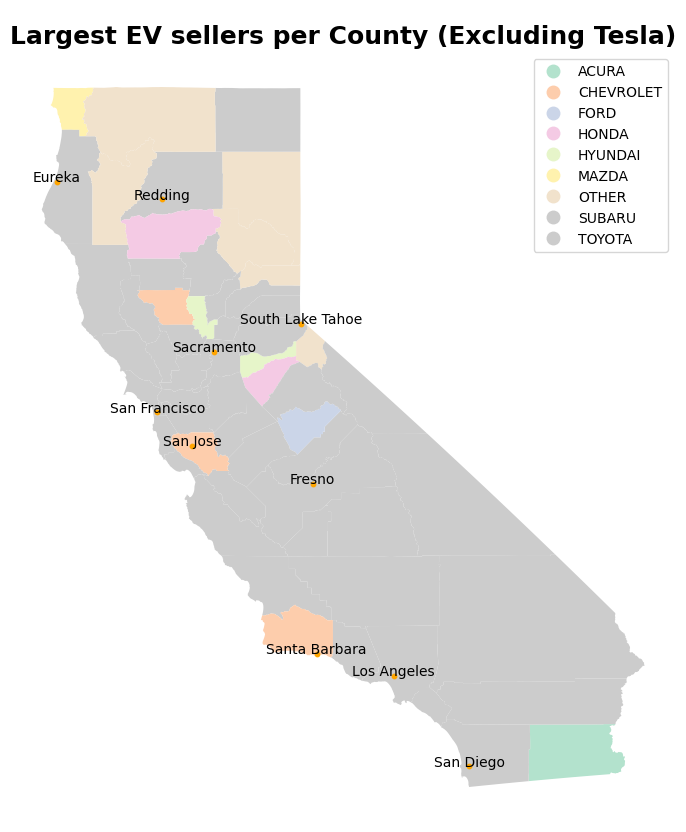

In [109]:
# Plot
# Who sells the most EVs per county?

fig, ax = plt.subplots(figsize = (10, 10))
county_gdf.plot(ax=ax,
                categorical = True,
                column='largest_maker',
                legend = True,
                cmap = 'Pastel2')
cities.plot(ax=ax,
           color = 'orange',
           markersize = 10)

for idx, row in cities.iterrows():
    plt.annotate(text=row['city'], xy=row['coords'], horizontalalignment='center', color='Black')

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

for edge in ['right', 'bottom', 'top','left']:
    ax.spines[edge].set_visible(False)
    
ax.set_title('Largest EV sellers per County (Excluding Tesla)', size=18, weight='bold')

In [110]:
# Save plot
fig.savefig('../pics/largest_ev_sellers_per_county_no_tesla.png')
plt.close(fig)